# Following the MATLAB example code

Following Hanser et. al.,

In [1]:
%load_ext autoreload
%autoreload 2
import os
import tqdm
from skimage.external import tifffile as tif
%pylab inline
from psfotf import *
from dphutils import scale
from dphplotting import mip, slice_plot, display_grid
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
test_data = tif.imread("../fixtures/BIL113_zstack_z300nm_current.tif")
params = dict(
    size = test_data.shape[-1],
    zsize = test_data.shape[0],
    na = 1.1,
    res = 90.5,
    zres = 300,
    wl = 605,
    ni = 1.33,
    vec_corr="none",
    condition="none"
)

C:\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:1398: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


(<matplotlib.figure.Figure at 0x268680c03c8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002686B478588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002686C992E80>], dtype=object))

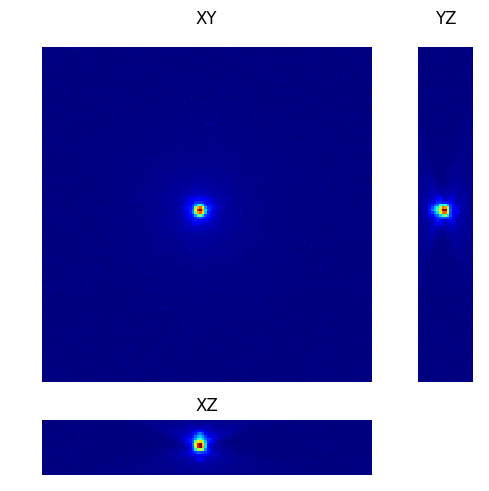

In [3]:
mip(test_data)

In [4]:
psf = HanserPSF(**params)

(<matplotlib.figure.Figure at 0x2686c9fbf28>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002686C9CF3C8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002686D7A0710>], dtype=object))

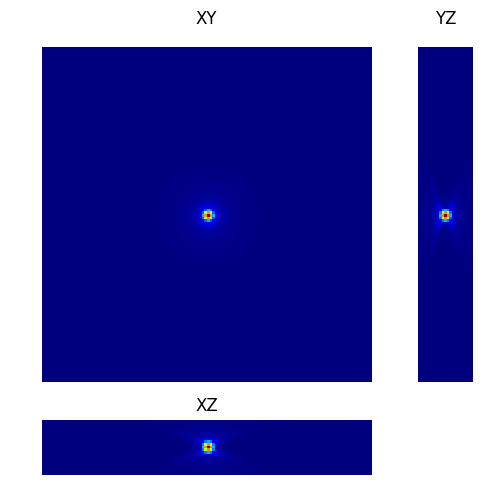

In [5]:
mip(psf.PSFi)

In [6]:
def retrieve_phase(mag, psf, pupil=None):
    """This function acurately reproduces the matlab code"""
    if pupil is None:
        # if first iteration, start with pupil of 1 over pass band
        pupil = psf._gen_pupil()
    psf._gen_psf(pupil)
    phase = angle(psf.PSFa.squeeze())
    #replace magnitude with sqrt of PSF
    new_psf = mag * exp(1j * phase)
    new_pupils = fftn(ifftshift(new_psf, axes=(1,2)), axes=(1,2))
    # undo focus
    new_pupil = (new_pupils / psf._calc_defocus()).mean(0)
    # save only the phase information, magnitude will be restricted to 1
    new_pupil = exp(1j * angle(new_pupil))
    return psf._gen_pupil() * new_pupil, new_pupils

19.699891567230225


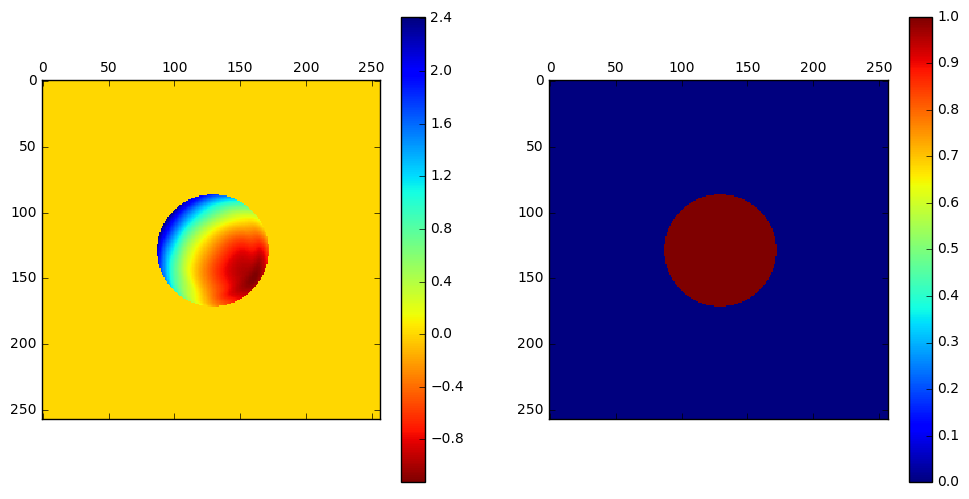

In [7]:
start = time.time()
npix = 257
PSF_measured = test_data.copy()
nz, ny, nx = PSF_measured.shape;
zc, yc, xc = unravel_index(PSF_measured.argmax(), PSF_measured.shape);
PSF_offset = 1.5 * bincount(PSF_measured.ravel()).argmax()
PSF = zeros((nz, npix, npix))
PSF[:, npix // 2 - yc:npix // 2 + ny - yc, npix // 2-xc:npix // 2 + nx - xc] = PSF_measured
PSF = sqrt(PSF)
PSF = PSF - sqrt(PSF_offset)
PSF *= PSF > 0

params.update(dict(size = npix))
psf = HanserPSF(**params)
pupil = None
psf._gen_kr()
for _ in range(25):
    pupil, pupils = retrieve_phase(PSF, psf, pupil, True)
fig, axs = subplots(1, 2, figsize = (12, 6))
img1 = axs[0].matshow(fftshift(angle(conj(pupil)) * psf._gen_pupil().real), cmap="jet_r")
colorbar(img1, ax=axs[0])
img2 = axs[1].matshow(fftshift(abs(pupil)))
colorbar(img2, ax=axs[1])
print(time.time()-start)

(<matplotlib.figure.Figure at 0x29238ff5240>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000029239027E80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002923896A5F8>], dtype=object))

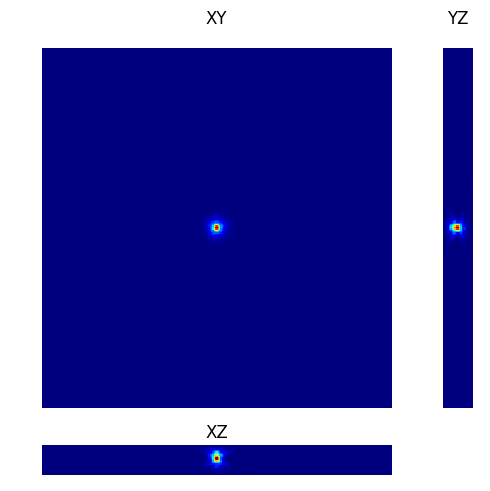

In [8]:
mip(PSF)

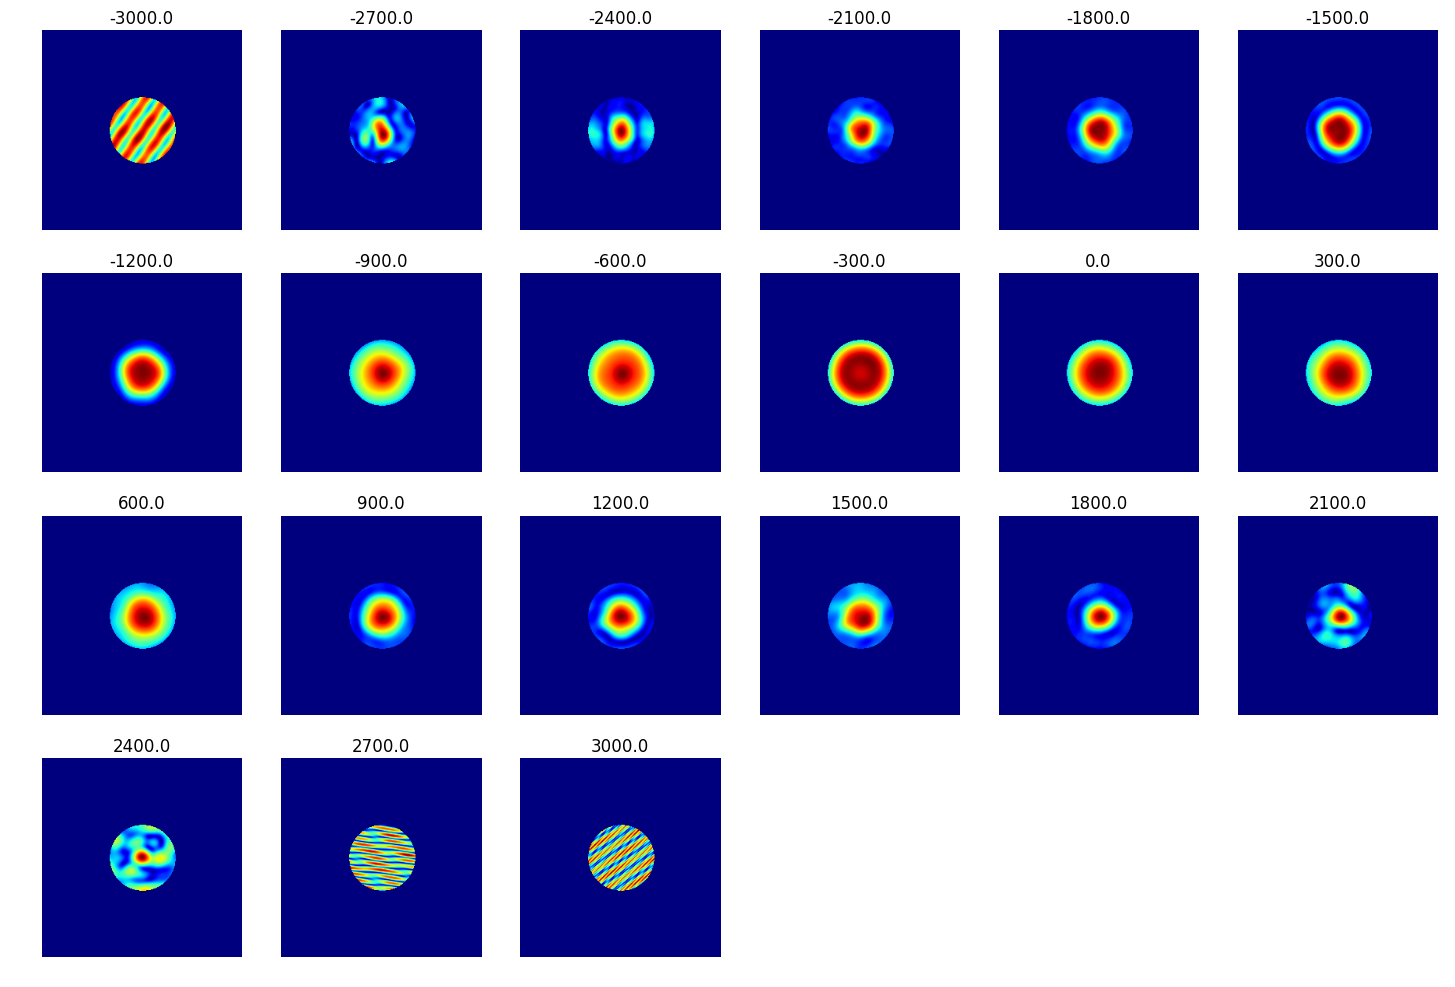

In [9]:
display_grid({z:fftshift(abs(pupil) * psf._gen_pupil().real) for z, pupil in zip(psf.zrange, pupils / psf._calc_defocus())});

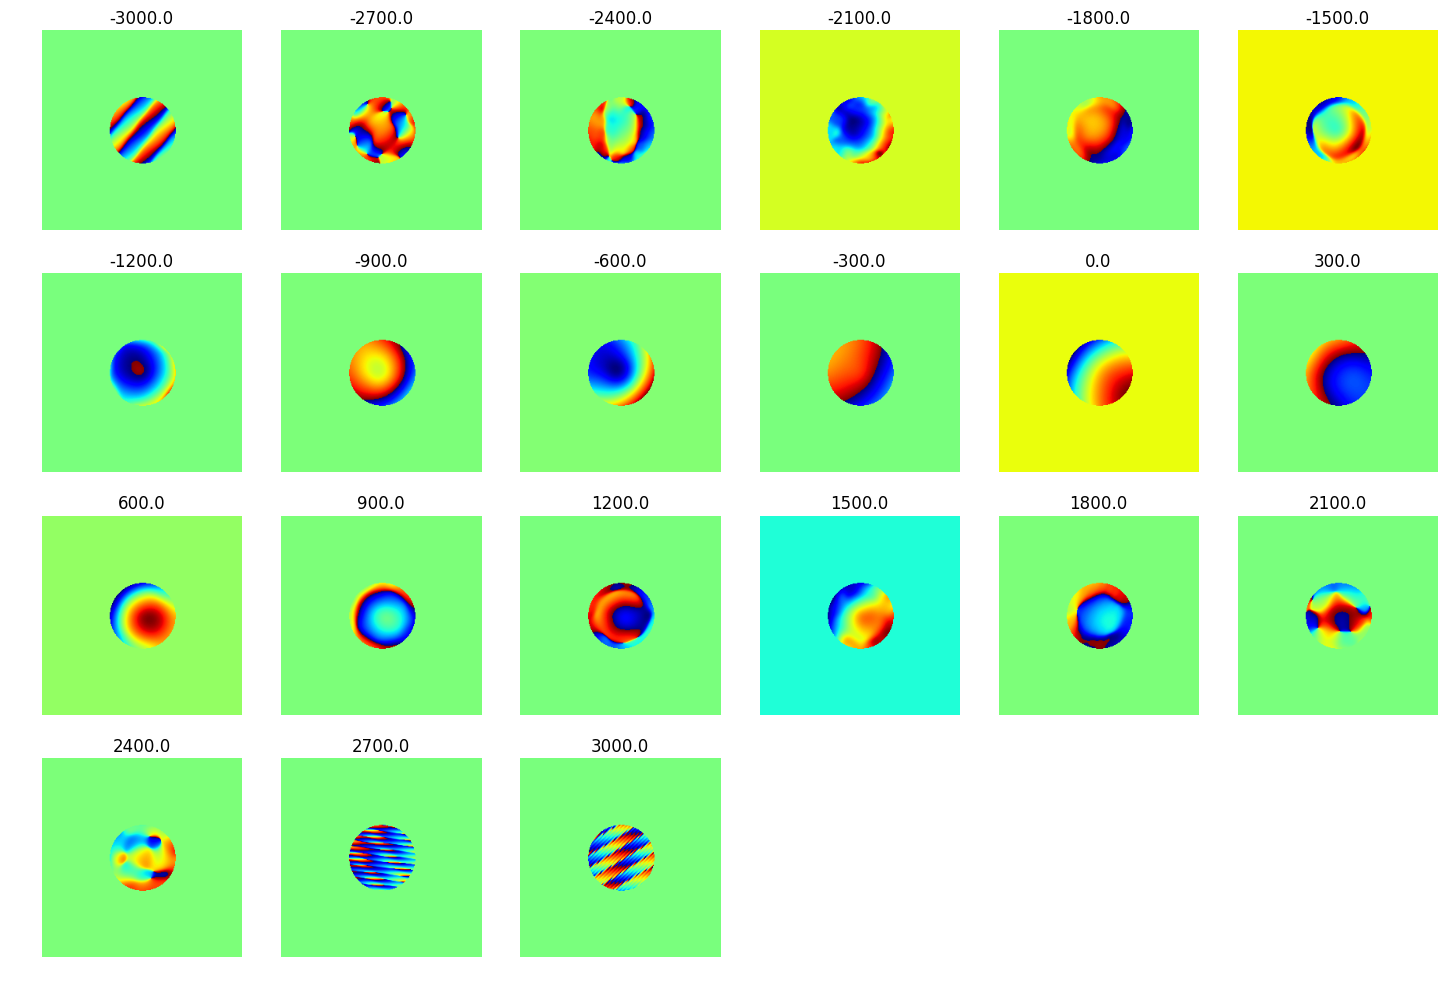

In [10]:
display_grid({z:fftshift(angle(pupil) * psf._gen_pupil().real) for z, pupil in zip(psf.zrange, pupils)});

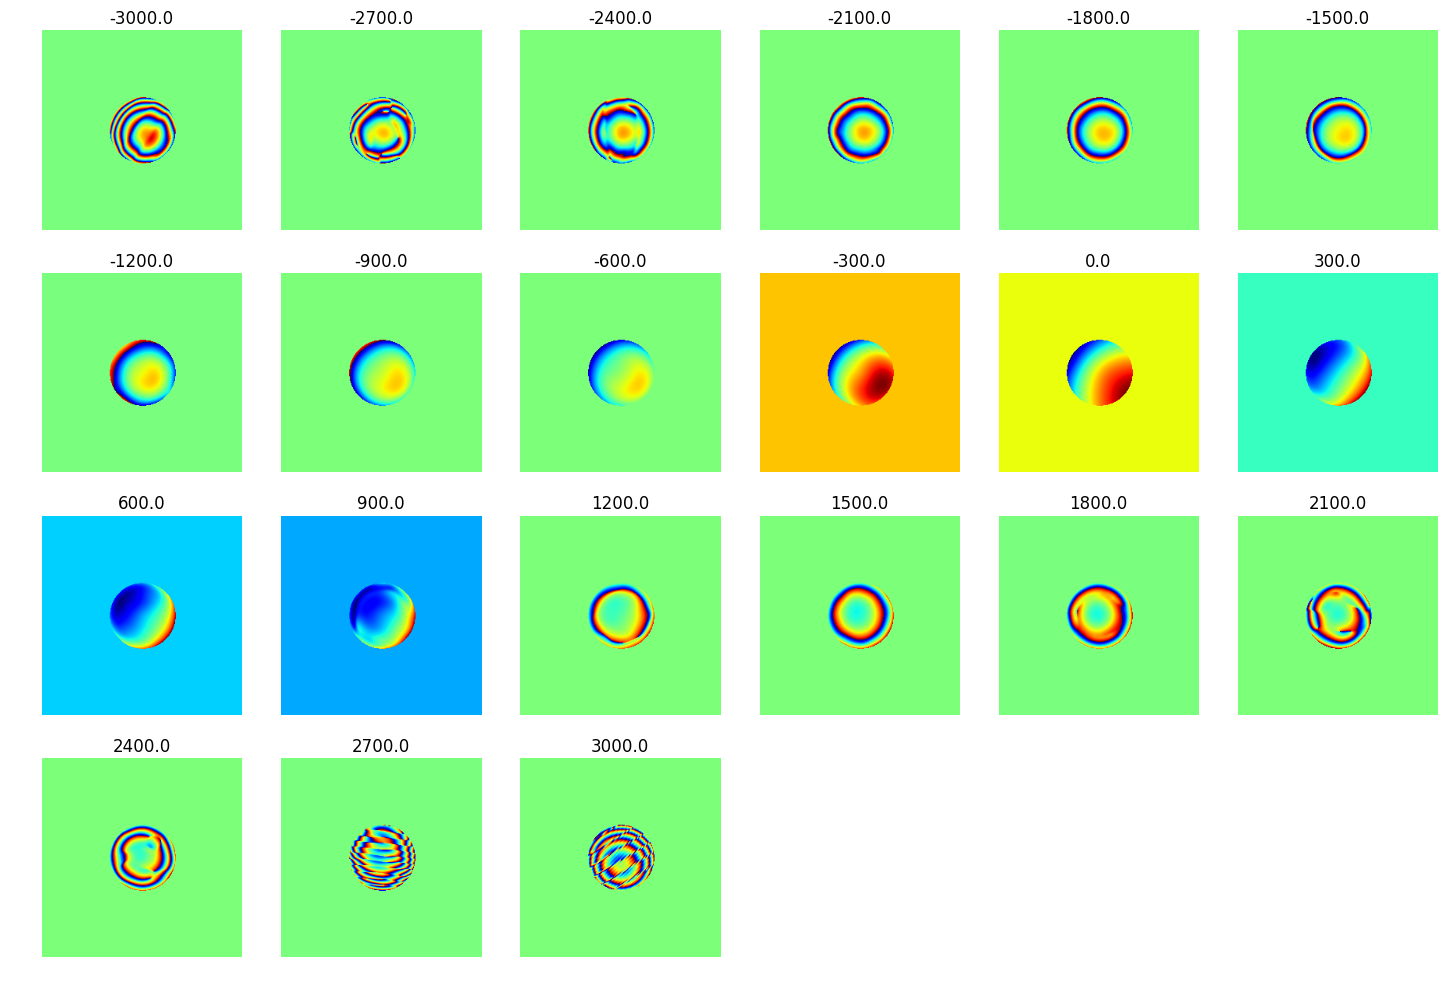

In [11]:
display_grid({z:fftshift(angle(pupil) * psf._gen_pupil().real) for z, pupil in zip(psf.zrange, pupils/psf._calc_defocus())});

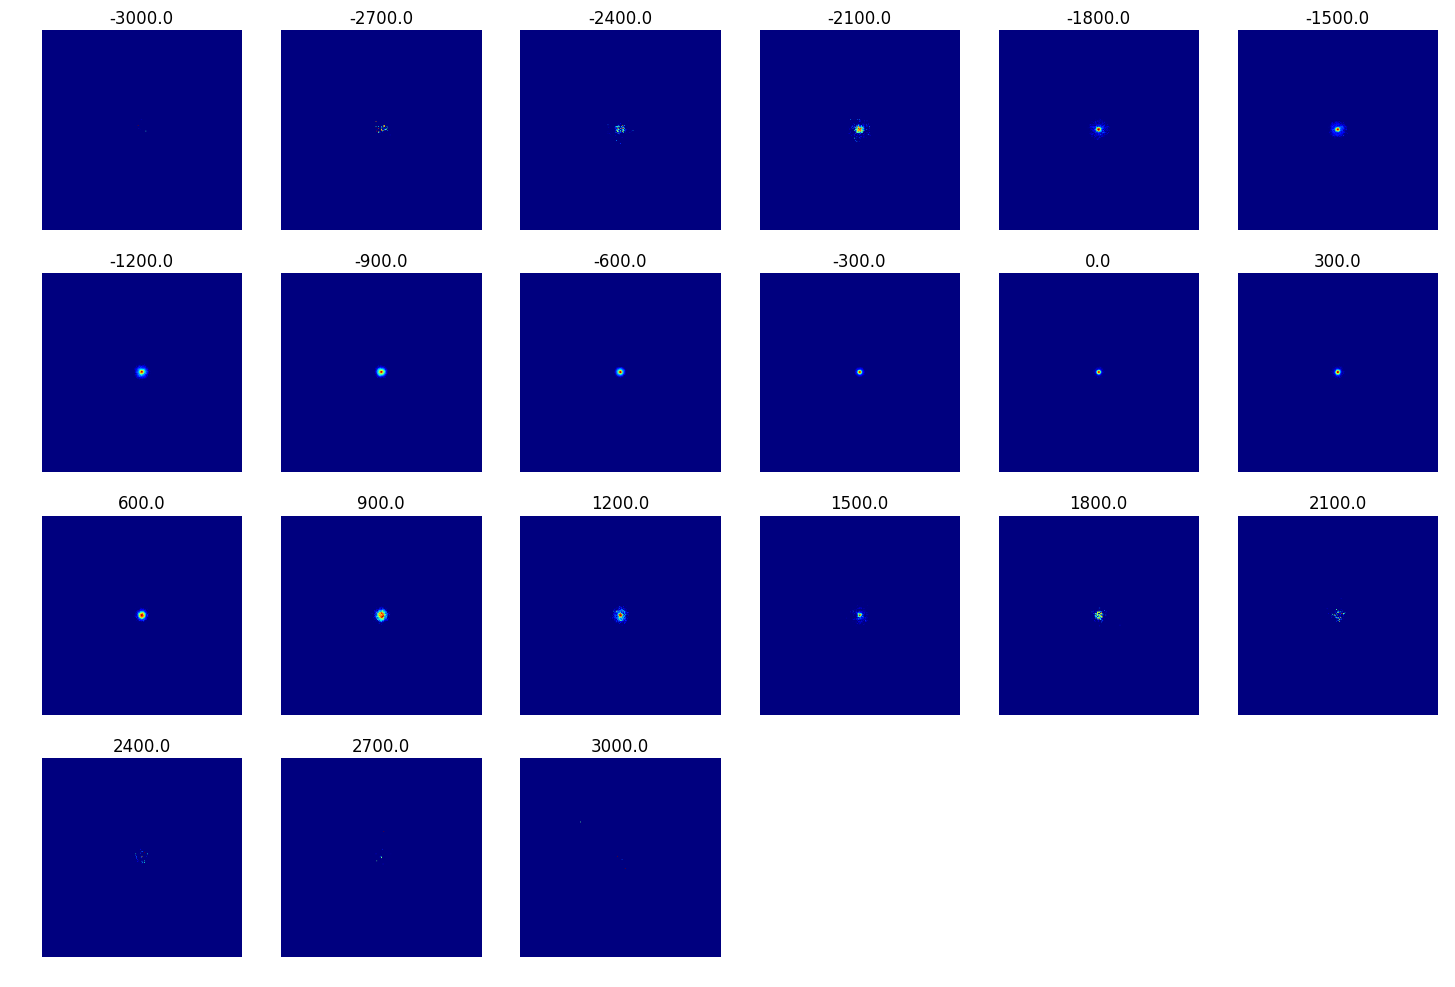

In [12]:
display_grid({z:p for z, p in zip(psf.zrange, PSF)});

The problem is that this data set gets clipped too much when removing background.